#### Universidade Federal de MInas Gerais - UFMG
#### Programa de Pós Graduação em Engenharia Elétrica - PPGEE
#### Técnicas de Modelagem e Controle de Conversores Estáticos
# Primeiro Projeto

Professor: Seleme Isaac Seleme Júnior

Aluno: Marco Vinicio Teixeira Andrade - 2020723055

## Bibliotecas Usadas

In [102]:
# Importação de biblioteacas
import matplotlib.pyplot as plt
import numpy as np
import control
import scipy
import pandas as pd

## Circuito Boost

![Imagem](Imagens/Boost.png)


In [103]:
# Parametros do Boost
Vg = 20 # Tensão de entrada em Volts
V = 50 # Tensão de saída em V
L = 20e-6 # Indutância em uH
RL = 0.1 # Resistência série do indutor em ohms
Ron = 0.05 # Resistência de condução MOSFET em ohms
C = 150e-6 # Capacitância de saída em uF
R = 10 # Carga em ohms
VD = 0.6 # Tensão de condução direta do Diodo em V

## Equações de estados


O boost possui dois estados, a corrente no indutor e a tensão no capacitor. Em condução contínua podemos levantar as equações para os estados com a chave Q ligada $Q_{on}$ e para a chave Q desligada $Q_{off}$. Definidos a matriz de estados:

$$ x =  \begin{bmatrix} x_1 \\ x_2 \end{bmatrix} = \begin{bmatrix} I_L \\ V_C \end{bmatrix} $$

E as entradas

$$ u = \begin{bmatrix} V_g \\ V_D \\ \Delta I_R \end{bmatrix} $$

E a saída

$$ y = V $$

#### Circuito para Q ligado ($Q_{on}$)


![Imagem](Imagens/Boost_Qon.png)

$$\frac{dI_L}{dt} =  -\frac{(R_L+R_{on})I_L}{L} + \frac{V_g}{L}$$

$$\frac{dV_C}{dt} = \frac{\Delta I_R}{C} -\frac{V_C}{RC}$$

$$ \dot{x} = Ax + Bu $$

$$ A = \begin{bmatrix} -\frac{R_L+R_{on}}{L} \quad &0 \\ 0 \quad & -\frac{1}{RC} \end{bmatrix}  \quad B = \begin{bmatrix} \frac{1}{L} \quad 0 \quad 0\\ 0 \quad 0 \quad\frac{1}{C}\end{bmatrix}$$

$$ y = Cx + Du $$

$$ C = \begin{bmatrix} 0 \quad 1 \end{bmatrix}  \quad D = \begin{bmatrix} 0 \quad 0 \end{bmatrix}$$

In [104]:
A_on = np.array([[-(RL+Ron)/L, 0],
       [0,-1/R/C]])
B_on = np.array([[1/L, 0, 0],
       [0, 0, 1/C]])

C_on = np.array([[0, 1]])
D_on = np.array([[0, 0,0]])

#### Circuito para Q desligado ($Q_{off}$)


![Imagem](Imagens/Boost_Qoff.png)

$$ \frac{dI_L}{dt} = \frac{V_g}{L} - \frac{R_LI_L}{L} - \frac{V_D}{L} - \frac{V_C}{L}$$

$$ \frac{dV_C}{dt} = \frac{I_L}{C} + \frac{\Delta I_R}{C} - \frac{V_C}{RC} $$

$$ \dot{x} = Ax + Bu $$

$$ A = \begin{bmatrix} -\frac{R_L}{L} \quad & -\frac{1}{L} \\ \frac{1}{C} \quad & -\frac{1}{RC} \end{bmatrix}  \quad B = \begin{bmatrix} \frac{1}{L} \quad &-\frac{1}{L} \quad 0 \\ 0 \quad &0 \quad \frac{1}{C} \end{bmatrix}$$

$$ y = Cx + Du $$

$$ C = \begin{bmatrix} 0 \quad 1 \end{bmatrix}  \quad D = \begin{bmatrix} 0 \quad 0 \end{bmatrix}$$

In [105]:
A_off = np.array([[-(RL)/L, -1/L],
       [1/C,-1/R/C]])
B_off = np.array([[1/L, -1/L, 0],
        [0,0, 1/C]])

C_off = np.array([0,1])
D_off = np.array([0,0,0])

## Calculo do ciclo de trabalho para V=50V

### Calculo para Boost Ideal

In [106]:
# Calcula-se o ciclo de trabalho do buck ideal para ser usado como solução inicial
d_ideal = (V - Vg)/V # D caso dosse um buck com 100% de rendimento
A_med = A_on*d_ideal + A_off*(1-d_ideal)
B_med = B_on*d_ideal + B_off*(1-d_ideal)

U = np.array([[Vg],[VD],[0]])

X_dideal = -np.linalg.inv(A_med)@B_med@U
print('d = ', d_ideal)
print('IL = ', X_dideal[0][0])
print('VC = ', X_dideal[1][0])

d =  0.6
IL =  11.421965317919042
VC =  45.687861271676304


### Calculo para o Boost com os parasitas modelados

In [107]:
# Calcula numericamente o ciclo de trabalho do conversor estudado
def equations(p): #Define o sistema de equações para cálculo de d
    # Parametros do conversor
    Vg = 20 # Tensão de entrada em Volts
    V = 50 # Tensão de saída em V
    L = 20e-6 # Indutância em uH
    RL = 0.1 # Resistência série do indutor em ohms
    Ron = 0.05 # Resistência de condução MOSFET em ohms
    C = 150e-6 # Capacitância de saída em uF
    R = 10 # Carga em ohms
    VD = 0.6 # Tensão de condução direta do Diodo em V

    # Estado Qon
    A_on = np.array([[-(RL+Ron)/L, 0],
                   [0,-1/R/C]])
    B_on = np.array([[1/L, 0, 0],
                   [0, 0, 1/C]])

    # Estado Qoff
    A_off = np.array([[-(RL)/L, -1/L],
                    [1/C,-1/R/C]])
    B_off = np.array([[1/L, -1/L, 0],
                    [0,0, 1/C]])

    # Sistema
    d, x = p

    A_med = A_on*d + A_off*(1-d)
    B_med = B_on*d + B_off*(1-d)
    eq = -np.linalg.inv(A_med)@B_med@U - np.array([[x],[50]])
    return (eq[0][0], eq[1][0])

d_real, iL_real = scipy.optimize.fsolve(equations, (0.6, 12.5))

A_med = A_on*d_real + A_off*(1-d_real)
B_med = B_on*d_real + B_off*(1-d_real)

U = np.array([[Vg],[VD],[0]])

X_dreal = -np.linalg.inv(A_med)@B_med@U

print('d = ', d_real)
print('IL = ', X_dreal[0][0])
print('VC = ', X_dreal[1][0])

d =  0.6411013083510111
IL =  13.9315080170111
VC =  50.00000000002684


## Funções das Perturbações

### Ciclo de trabalho

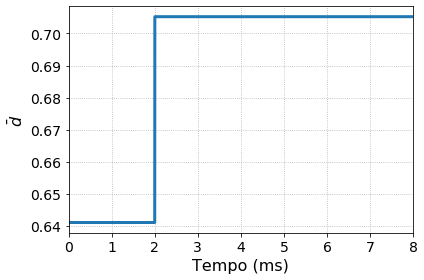

In [108]:
# Função f_d(t) - ciclo de trabalho do MOSFET Q
def f_d(t):
    if t < 2e-3:
        return 0.641101308349675
    else:
        return 0.641101308349675*1.1

# Vetor de Tempo
t = np.linspace(0, 8e-3, 80000)

# Vetor com valor instantaneo de d
d_inst = []

# Calculo de d_inst
for i in t:
    d_inst.append(f_d(i))    

plt.plot(t*1e3, d_inst, linewidth=3)
plt.xlabel(r'Tempo (ms)', fontsize=16)
plt.ylabel(r'$\bar{d}$', fontsize=16)
plt.grid(which='both', linestyle=':')
plt.xlim(0,8)
plt.gca().tick_params(axis='both', which='major', labelsize=14)
plt.tight_layout()
plt.savefig('Relatorio/Imagens/Graficos/bard.pdf')
plt.show()



### Comando da Chave

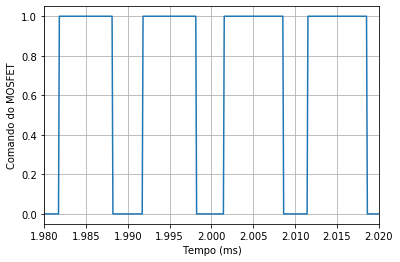

In [109]:
# Função f_u(t) - comando da chave no modelo chaveado
def f_u(t):
    
    T = 1/100e3

    duty = f_d(t)

    norm_t = t - np.floor(t/T)*T
    if norm_t > (1-duty)/2*T and norm_t <= (T-(1-duty)/2*T):
        return 1
    else:
        return 0

# Vetor com valor instantaneo de d
u_inst = []

# Calculo de d_inst
for i in t:
    u_inst.append(f_u(i))    

plt.plot(t*1e3, u_inst)
plt.xlabel(r'Tempo (ms)')
plt.ylabel(r'Comando do MOSFET')
plt.grid(which='both')
plt.xlim(198e-2,202e-2)
plt.show()


### Tensão de Entrada $V_g$

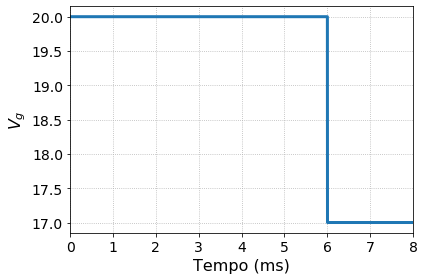

In [110]:
# Função f_Vg(t) da tensão de entrada do boost
def f_Vg(t):
    if t < 6e-3:
        return  20
    else:
        return 0.85*20

# Vetor com valor instantaneo de vg
vg_inst = []

# Calculo de d_inst
for i in t:
    vg_inst.append(f_Vg(i))    

plt.plot(t*1e3, vg_inst, linewidth=3)
plt.xlabel(r'Tempo (ms)', fontsize=16)
plt.ylabel(r'$V_g$', fontsize=16)
plt.grid(which='both', linestyle=':')
plt.xlim(0,8)
plt.gca().tick_params(axis='both', which='major', labelsize=14)
plt.tight_layout()
plt.savefig('Relatorio/Imagens/Graficos/Vg.pdf')
plt.show()

### Variação de Carga $\Delta I_R$

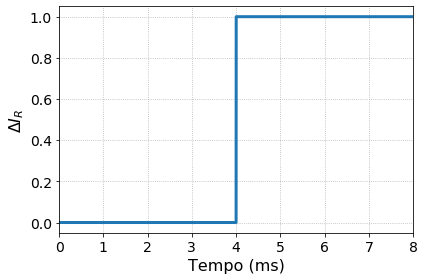

In [111]:
# Função f_DeltaIR(t) de degrau de carga
def f_DeltaIR(t):
    if t < 4e-3:
        return 0
    else:
        return 1

# Vetor com valor instantaneo de vg
deltaIR_inst = []

# Calculo de d_inst
for i in t:
    deltaIR_inst.append(f_DeltaIR(i))    

plt.plot(t*1e3, deltaIR_inst, linewidth=3)
plt.xlabel(r'Tempo (ms)', fontsize=16)
plt.ylabel(r'$\Delta I_R$', fontsize=16)
plt.grid(which='both', linestyle=':')
plt.xlim(0,8)
plt.gca().tick_params(axis='both', which='major', labelsize=14)
plt.tight_layout()
plt.savefig('Relatorio/Imagens/Graficos/DeltaIR.pdf')
plt.show()

## Modelo Chaveado

In [112]:
# Modelo chaveado
def boost_chaveado(x, t):
   # Parametros do Boost
   L = 20e-6 # Indutância em uH
   RL = 0.1 # Resistência série do indutor em ohms
   Ron = 0.05 # Resistência de condução MOSFET em ohms
   C = 150e-6 # Capacitância de saída em uF
   R = 10 # Carga em ohms
   VD = 0.6 # Tensão de condução direta do Diodo em V
   
   # Condicoes Iniciais
   X = np.array([[x[0]],
                [x[1]]])

   # Estado Qon
   A_on = np.array([[-(RL+Ron)/L, 0],
                   [0,-1/R/C]])
   B_on = np.array([[1/L, 0, 0],
                   [0, 0, 1/C]])

   # Estado Qoff
   A_off = np.array([[-(RL)/L, -1/L],
                    [1/C,-1/R/C]])
   B_off = np.array([[1/L, -1/L, 0],
                    [0,0, 1/C]])

   # Perturbações
   U = np.array([[f_Vg(t)],[VD],[f_DeltaIR(t)]])
   
   # Calculo do Modelo
   xd = (A_off + f_u(t)*(A_on - A_off))@X + (B_off + f_u(t)*(B_on - B_off))@U

   return [xd[0][0], xd[1][0]]

### Solução para o modelo

In [113]:
# Resolve o modelo chaveado
t_chaveado = np.linspace(0, 8e-3, 80000)

# store solution
I_Mchaveado = np.empty_like(t_chaveado)
V_Mchaveado = np.empty_like(t_chaveado)
# record initial conditions
x0 = [13.93150802, 50]
I_Mchaveado[0] = x0[0]
V_Mchaveado[0] = x0[1]

for i in range(1,len(t_chaveado)):
    # span for next time step
    tspan = [t_chaveado[i-1],t_chaveado[i]]
    # solve for next step
    x = scipy.integrate.odeint(boost_chaveado,x0,tspan)
    # store solution for plotting
    I_Mchaveado[i] = x[1][0]
    V_Mchaveado[i] = x[1][1]
    # next initial condition
    x0 = x[1]

### Saidas do Modelo

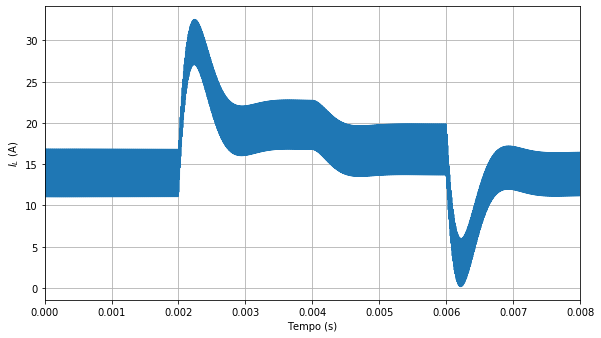

In [114]:
# Plota da Corrente calculada pelo modelo chaveado 
plt.plot(t_chaveado, I_Mchaveado)
plt.xlabel(r'Tempo (s)')
plt.ylabel(r'$I_L$ (A)')
plt.grid(which='both')
plt.xlim(0,8e-3)
plt.gcf().set_size_inches(9.6, 5.4)
plt.show()

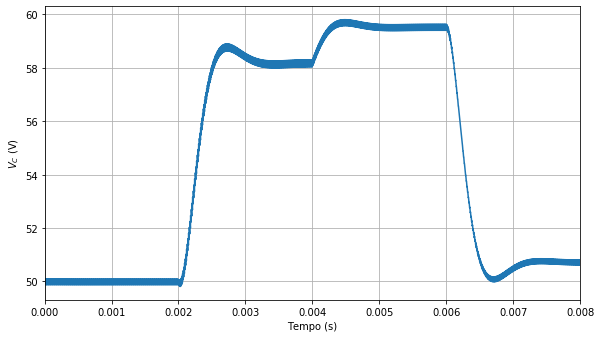

In [115]:
# Plot da Tensão calculada pelo modelo chaveado 
plt.plot(t_chaveado, V_Mchaveado)
plt.xlabel(r'Tempo (s)')
plt.ylabel(r'$V_C$ (V)')
plt.grid(which='both')
plt.xlim(0,8e-3)
plt.gcf().set_size_inches(9.6, 5.4)
plt.show()

## Modelo Médio Não Linear

In [116]:
# Parametros do Boost
boost_params = {
    'L': 20e-6, # Indutância em uH
    'RL': 0.1, # Resistência série do indutor em ohms
    'Ron': 0.05, # Resistência de condução MOSFET em ohms
    'C': 150e-6, # Capacitância de saída em uF
    'R': 10, # Carga em ohms
    }

In [117]:
def boost_update(t, x, u, params={}):
    # Lê os Parametros do modelo
    L = params.get('L', 20e-6) # Indutância em uH
    RL = params.get('RL', 0.1) # Indutância em uH
    Ron = params.get('Ron', 0.05) # Indutância em uH
    C = params.get('C', 150e-6) # Indutância em uH
    R = params.get('R', 10) # Indutância em uH

    # Tranforma entrada em vetor coluna
    X = np.vstack([x[0], x[1]])

    # Lê as entradas
    Vg = u[0]
    VD = u[1]
    deltaIR = u[2]
    d = u[3] # função de chaveamento ou ciclo de trabalho
    U = np.vstack([Vg, VD, deltaIR])

    # Matriz de estados para Qon
    A_on = np.array([[-(RL+Ron)/L, 0],
                   [0,-1/R/C]])
    B_on = np.array([[1/L, 0, 0],
                   [0, 0, 1/C]])

    # Matriz de estados para Qoff
    A_off = np.array([[-(RL)/L, -1/L],
                    [1/C,-1/R/C]])
    B_off = np.array([[1/L, -1/L, 0],
                    [0,0, 1/C]])

    # Matriz de combinada
    A = A_on*d + (1-d)*A_off
    B = B_on*d + (1-d)*B_off

    # Calcula o sistema
    xd = A@X + B@U
    
    # Return the derivative of the state
    return xd.T[0]

In [118]:
# Define o Boost  como um sistema de entrada saida não linear
boost = control.NonlinearIOSystem(
    boost_update, None, states=2, name='Boost',
    inputs=('Vg', 'VD', 'deltaIR', 'd'), outputs=('IL', 'VC'), params=boost_params)

print(boost)

System: Boost
Inputs (4): Vg, VD, deltaIR, d, 
Outputs (2): IL, VC, 
States (2): x[0], x[1], 


### Solução para o modelo

In [119]:
# Tempo da simulção
t_mNaoLinear = np.linspace(0, 8e-3, 8000)

# Vetores das entradas
Vg_inst = np.array([f_Vg(i) for i in t_mNaoLinear])
VD_inst = 0.6*np.ones(t_mNaoLinear.shape)
deltaIR_inst = np.array([f_DeltaIR(i) for i in t_mNaoLinear])
d_inst = np.array([f_d(i) for i in t_mNaoLinear])

# Combinação das entradas para modelo chaveado
inputs = [Vg_inst, VD_inst, deltaIR_inst, d_inst]

# Condições iniciais
x0 = [13.9, 50]

In [120]:
# Simulação
solve_ivp_args = {
    'dense_output': False, # Indutância em uH
    'rtol': 1e-4, # Resistência série do indutor em ohms
    'atol': 1e-6, # Resistência de condução MOSFET em ohms
    'max_step': 1/10/100e3,
    'dense_output': True
    }

t_0, y, x = control.input_output_response(boost, t_mNaoLinear, inputs, x0, params=boost_params,
 return_x=True, solve_ivp_method='BDF' ,solve_ivp_kwargs=solve_ivp_args)

I_MmedioNaoLinear = y[0]
V_MmedioNaoLinear = y[1]

### Saidas do Modelo

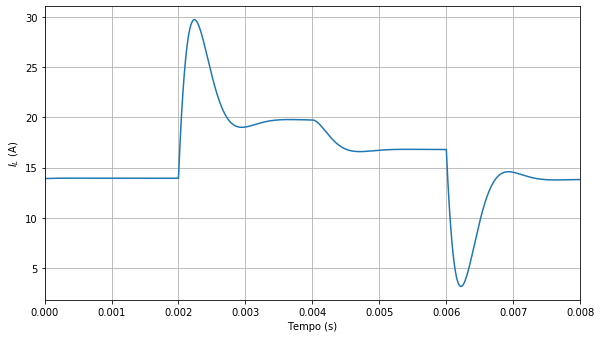

In [121]:
# Plota da Corrente calculada pelo modelo chaveado 
plt.plot(t_mNaoLinear, I_MmedioNaoLinear)
plt.xlabel(r'Tempo (s)')
plt.ylabel(r'$I_L$ (A)')
plt.grid(which='both')
plt.xlim(0,8e-3)
plt.gcf().set_size_inches(9.6, 5.4)
plt.show()

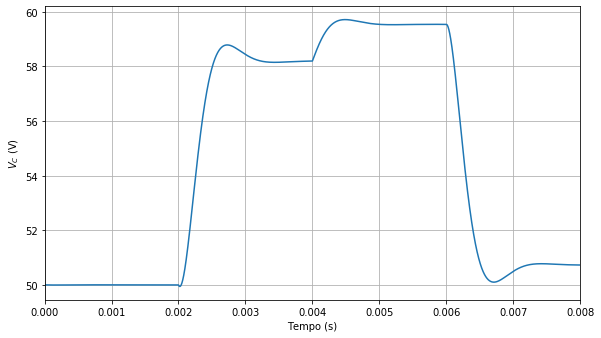

In [122]:
# Plot da Tensão calculada pelo modelo chaveado 
plt.plot(t_mNaoLinear, V_MmedioNaoLinear)
plt.xlabel(r'Tempo (s)')
plt.ylabel(r'$V_C$ (V)')
plt.grid(which='both')
plt.xlim(0,8e-3)
plt.gcf().set_size_inches(9.6, 5.4)
plt.show()

## Modelo Pequenos Sinais

In [123]:
# Vetor de tempo
t_ps = np.linspace(0, 8e-3, 800)

# Calcula as matrizes médias
A_ps = A_on*d_real + A_off*(1-d_real)
B_ps = B_on*d_real + B_off*(1-d_real)

# Entradas médias 
U_ps = np.array([[Vg],[VD],[0]])

# Valores medios das saidas
X_ps = -np.linalg.inv(A_ps)@B_ps@U_ps

# Adiciona as constantes de porporcionalidade a entrada de perturbação no ciclo de trabalho
B_ps = np.c_[B_ps,((A_on-A_off)@X_ps + (B_on-B_off)@U_ps)]

# Matriz de saidas
C_ps = np.array([[1,0],[0,1]])
D_ps = np.array([[0,0,0,0],[0,0,0,0]])


# Cria o sisrema
sys_ps = control.ss(A_ps, B_ps, C_ps, D_ps)

### Saidas do Modelo

In [124]:
# Monta a matriz de entradas retirando os valores médios
Vg_ps = np.array([f_Vg(t)-Vg for t in t_ps])
VD_ps = np.zeros(len(t_ps))
deltaIR_ps = np.array([f_DeltaIR(t) for t in t_ps])
d_ps = np.array([f_d(t)-d_real for t in t_ps])

inputs = np.vstack([Vg_ps, VD_ps, deltaIR_ps , d_ps])

# Calcula as saidas
out = control.forced_response(sys_ps, t_ps, inputs , [0,0])
I_MpequenosSinais = np.add(out[1][0], X_ps[0])
V_MpequenosSinais = np.add(out[1][1], X_ps[1])

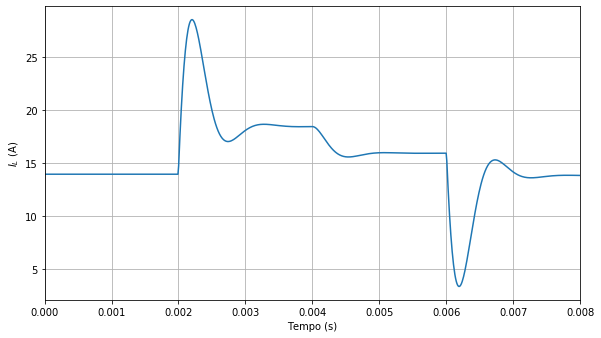

In [125]:
# Plota da Corrente calculada pelo modelo chaveado 
plt.plot(t_ps, I_MpequenosSinais)
plt.xlabel(r'Tempo (s)')
plt.ylabel(r'$I_L$ (A)')
plt.grid(which='both')
plt.xlim(0,8e-3)
plt.gcf().set_size_inches(9.6, 5.4)
plt.show()

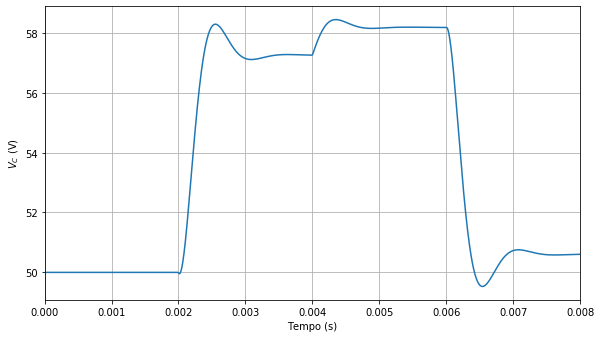

In [126]:
# Plot da Tensão calculada pelo modelo chaveado 
plt.plot(t_ps,V_MpequenosSinais)
plt.xlabel(r'Tempo (s)')
plt.ylabel(r'$V_C$ (V)')
plt.grid(which='both')
plt.xlim(0,8e-3)
plt.gcf().set_size_inches(9.6, 5.4)
plt.show()

## Comparação dos Resultados

### Corrente de Entrada

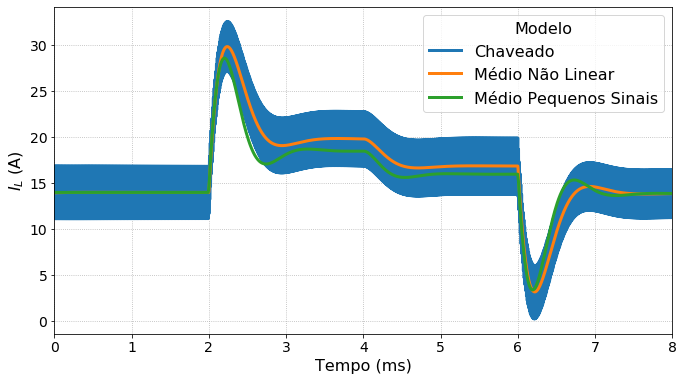

In [127]:
# Resultados de Corrente
plt.plot(t_chaveado*1e3,I_Mchaveado, label='Chaveado', linewidth=3)
plt.plot(t_mNaoLinear*1e3,I_MmedioNaoLinear, label='Médio Não Linear', linewidth=3)
plt.plot(t_ps*1e3,I_MpequenosSinais, label='Médio Pequenos Sinais', linewidth=3)
plt.xlabel(r'Tempo (ms)', fontsize=16 )
plt.ylabel(r'$I_L$ (A)', fontsize=16)
plt.xlim(0,8)
plt.gcf().set_size_inches(9.6, 5.4)
plt.legend(title='Modelo', fontsize=16).get_title().set_fontsize('16')
plt.grid(which='both', linestyle=':')
plt.xlim(0,8)
plt.gca().tick_params(axis='both', which='major', labelsize=14)
plt.tight_layout()
plt.savefig('Relatorio/Imagens/Graficos/Resultados_IL.pdf')
plt.show()

### Tensão de Saída

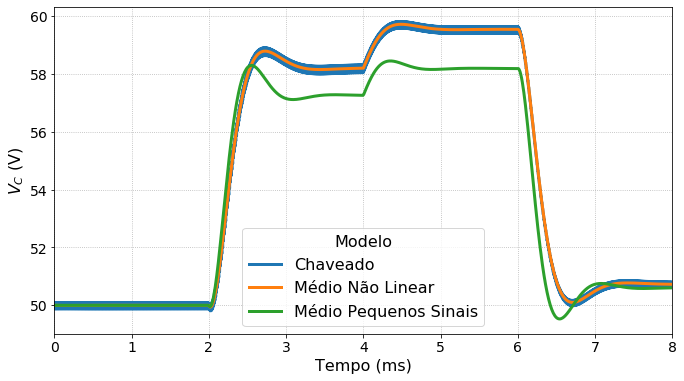

In [128]:
# Resultados de Corrente
plt.plot(t_chaveado*1e3,V_Mchaveado, label='Chaveado', linewidth=3)
plt.plot(t_mNaoLinear*1e3,V_MmedioNaoLinear, label='Médio Não Linear', linewidth=3)
plt.plot(t_ps*1e3,V_MpequenosSinais, label='Médio Pequenos Sinais', linewidth=3)
# plt.plot(t_ps*1e3,V_FT, label='Médio Pequenos Sinais (FT)', linestyle='--')
plt.xlabel(r'Tempo (ms)', fontsize=16)
plt.ylabel(r'$V_C$ (V)', fontsize=16)
plt.xlim(0,8)
plt.gcf().set_size_inches(9.6, 5.4)
plt.legend(title='Modelo', fontsize=16).get_title().set_fontsize('16')
plt.grid(which='both', linestyle=':')
plt.xlim(0,8)
plt.gca().tick_params(axis='both', which='major', labelsize=14)
plt.tight_layout()
plt.savefig('Relatorio/Imagens/Graficos/Resultados_VC.pdf')
plt.show()

## Resistência Crítica

### Caso Ideal

$$ P_{in} = P_{out} $$
$$ V_g \bar{I_L} = \frac{V^2}{R} $$
$$ V_g \bar{I_L} = \frac{V_g^2}{(1-d)^2R} $$
$$ \bar{I_L} = \frac{V_g}{(1-d)^2R} $$

$$ \Delta I_L = \frac{V_gd}{Lf_s}$$

O limite para a condução continua é quando $\bar{I_L} = \frac{\Delta I_L}{2}$. Igualando:
$$ R = \frac{2Lf_s}{d(1-d)^2} $$


In [129]:
# Para o boost ideal
Rcrit_ideal = 2*L*100e3/d_real/(1-d_real)/(1-d_real)

print(Rcrit_ideal)

48.43837642498053


### Caso Real

In [130]:
# Calcula numericamente a resistência critica para o conversor com os parasitas estudados
def r_critico(p):
    # Parametros do conversor
    Vg = 20 # Tensão de entrada em Volts
    V = 50 # Tensão de saída em V
    L = 20e-6 # Indutância em uH
    RL = 0.1 # Resistência série do indutor em ohms
    Ron = 0.05 # Resistência de condução MOSFET em ohms
    C = 150e-6 # Capacitância de saída em uF
    VD = 0.6 # Tensão de condução direta do Diodo em V
    d = 0.6411013083510234
    Ts = 1/100e3
    # Sistema
    R, V = p

    # Estado Qon
    A_on = np.array([[-(RL+Ron)/L, 0],
                   [0,-1/R/C]])
    B_on = np.array([[1/L, 0, 0],
                   [0, 0, 1/C]])

    # Estado Qoff
    A_off = np.array([[-(RL)/L, -1/L],
                    [1/C,-1/R/C]])
    B_off = np.array([[1/L, -1/L, 0],
                    [0,0, 1/C]])

    # Modelo médio
    A_med = A_on*d + A_off*(1-d)
    B_med = B_on*d + B_off*(1-d)

    # Entradas
    U = np.array([[Vg],[VD],[0]])

    # Ripple de corrente
    deltaIL = Vg/(RL+Ron)*(1-np.exp(-d*Ts*(Ron+RL)/L))

    # Resolve o circuito édio
    A_med = np.array(A_med, dtype=np.float)
    B_med = np.array(B_med, dtype=np.float)
    eq = -np.linalg.inv(A_med)@B_med@U - np.array([[deltaIL/2],[V]])
    return (eq[0][0], eq[1][0])

Rcrit_real, Vcrit_real = scipy.optimize.fsolve(r_critico, (Rcrit_ideal,50))

# print(r_critico(47))

deltaIL = Vg/(RL+Ron)*(1-np.exp(-d_real/100e3*(Ron+RL)/L))
print('R critico = ', Rcrit_real)
print('V = ', Vcrit_real)
print('I_L = ', deltaIL)


R critico =  48.052850418202866
V =  53.97448766547459
I_L =  6.259324898157487


## Controle

### Modelo da Planta

O sistema é representado pelo seguinte diagrama de blocos.

![Imagem](Imagens/Controle.png)

In [131]:
Vm = 4
Vref = 5

#### Funções de Transfêrencia

##### $G_{d}(s)$

In [132]:
# Calculo gvd
B_d = B_ps[:,3]
C_d = np.array([0,1])
D_d = np.array([[0]])

sys_ps_gvg = control.ss(A_ps, B_d, C_d, D_d)
gvd_ps = control.ss2tf(sys_ps_gvg)

# w = np.linspace(0.01*2*np.pi, 1e6*2*np.pi)
# mag, phase, omega = control.freqresp(gvd_ps, w)
print(gvd_ps)
# plt.plot(w, mag)
# plt.xscale('log')



-9.288e+04 s + 5.357e+09
------------------------
s^2 + 7269 s + 4.734e+07



##### $G_{V_g}(s)$

In [133]:
# Calculo gvg
B_Vg = B_ps[:,0]
C_Vg = np.array([0,1])
D_Vg= np.array([[0]])

sys_ps_gvd = control.ss(A_ps, B_Vg, C_Vg, D_Vg)
gvg_ps = control.ss2tf(sys_ps_gvd)

print(gvg_ps)


-1.819e-12 s + 1.196e+08
------------------------
s^2 + 7269 s + 4.734e+07



##### $Z_{out}(s)$

In [134]:
# Calculo zout
B_zout = B_ps[:,2]
C_zout = np.array([0,1])
D_zout = np.array([[0]])

sys_ps_zout = control.ss(A_ps, B_zout, C_zout, D_zout)
zout_ps = control.ss2tf(sys_ps_zout)

print(zout_ps)


   6667 s + 4.402e+07
------------------------
s^2 + 7269 s + 4.734e+07



##### Saída do modelo

In [135]:
# Calcula as saidas de cada FT
out_gvd = control.forced_response(gvd_ps, t_ps, d_ps , [0,0])
out_zout = control.forced_response(zout_ps, t_ps, deltaIR_ps , [0,0])
out_gvg = control.forced_response(gvg_ps, t_ps, Vg_ps , [0,0])

# Soma todas as funções de transferencia
V_FT = np.add((out_gvd[1] + out_gvg[1] + out_zout[1]), X_ps[1])

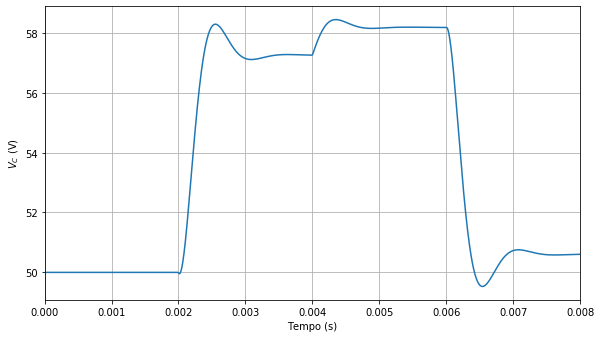

In [136]:
# Plot da Tensão calculada pelo modelo chaveado 
plt.plot(t_ps,V_FT)
plt.xlabel(r'Tempo (s)')
plt.ylabel(r'$V_C$ (V)')
plt.grid(which='both')
plt.xlim(0,8e-3)
plt.gcf().set_size_inches(9.6, 5.4)
plt.show()

### Projeto do controlador

#### Caracterização do loop de controle

In [137]:
# Primeira é levantada a função de transferencia do loop de controle com Cv = 1
PWM = control.tf(1,Vm) # Valor medio da saida do PWM
H = control.tf(Vref,V) # Realimentação 
Cv = 1

FTMA = Cv*PWM*gvd_ps*H # LOOP com controle unitário
print(FTMA)


    -4.644e+05 s + 2.678e+10
---------------------------------
200 s^2 + 1.454e+06 s + 9.468e+09



A função de transferencia do loop é caracterizada por sua resposta em frequência

In [138]:
# Define o vetor de frequencias para a simulação
w = np.logspace(0, 7, 1000)

# Cáclula marge de ganho de fase, frequencia de crossover(wc) e frequencia onde a dase crusa -180.
margem_ganho, margem_fase, w_mg, wc = control.margin(FTMA)

mag_FTMA, fase_FTMA, w = control.freqresp(FTMA, w)

fase_FTMA = np.array([fase if fase < 0 else -np.pi - (np.pi-fase) for fase in fase_FTMA])

Q = np.max(mag_FTMA) - mag_FTMA[0] # fator de qualidade
f0 = w[mag_FTMA.tolist().index(np.max(mag_FTMA))]/2/np.pi # frequencia do polo
fc = wc/2/np.pi # frequencia de crossover

print('Q = ', Q)
print('f0 = ', f0)
print('fc = ', fc)
print('Margem de Fase = ', margem_fase)
print('Margem de Ganho = ', margem_ganho)

Q =  0.3344569802127526
f0 =  735.3342525919006
fc =  1956.3293190353668
Margem de Fase =  28.70488096968046
Margem de Ganho =  3.130782365556344


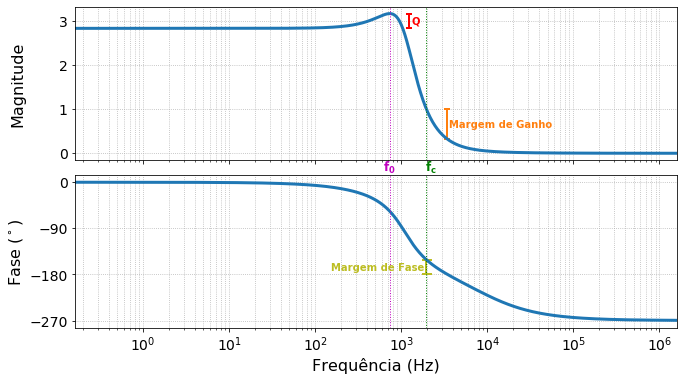

In [139]:
# Grafico de Bode da FTMA
fig, ax = plt.subplots(2,1, sharex='col')

ax[0].plot(w/2/np.pi, mag_FTMA, linewidth=3)
ax[1].plot(w/2/np.pi, fase_FTMA*180/np.pi, linewidth=3)

ax[1].set_xlabel(r'Frequência (Hz)', fontsize=16)
ax[0].set_ylabel(r'Magnitude', fontsize=16)
ax[1].set_ylabel(r'Fase ($^\circ$)', fontsize=16)

ax[1].set_xscale('log')

ax[1].set_xlim(w[0]/2/np.pi,w[-1]/2/np.pi)
ax[1].set_ylim(-285,15)
ax[1].set_yticks([-270, -180, -90, 0])

fig.set_size_inches(9.6, 5.4)

ax[0].grid(which='both', linestyle=':')
ax[1].grid(which='both', linestyle=':')

ax[0].tick_params(axis='both', which='major', labelsize=14)
ax[1].tick_params(axis='both', which='major', labelsize=14)


# Indicando os parametros medidos
# Q
ax[0].vlines(f0+500, mag_FTMA[0], np.max(mag_FTMA), linewidth=2, color='r')
ax[0].hlines(mag_FTMA[0], f0+400, f0+600, linewidth=2, color='r')
ax[0].hlines(mag_FTMA[0]+Q, f0+400, f0+600, linewidth=2, color='r')
ax[0].annotate(s='Q', xy =(f0+575,mag_FTMA[0]+Q/2), verticalalignment='center', horizontalalignment='left' , rotation = 0, color='r', weight='bold')

# f0
ax[0].axvline(f0, linewidth=1, linestyle=':', color='m')
ax[1].axvline(f0, linewidth=1, linestyle=':', color='m')
plt.gcf().text(0.56, 0.5475, r'$\mathbf{f_0}$', color='m', fontsize=12, weight='bold')

# fc
ax[0].axvline(fc, linewidth=1, linestyle=':', color='g')
ax[1].axvline(fc, linewidth=1, linestyle=':', color='g')
plt.gcf().text(0.62, 0.5475, r'$\mathbf{f_c}$', color='g', fontsize=12, weight='bold')

# Margem de fase
ax[1].vlines(fc, -180, -180+margem_fase, linewidth=2, color='tab:olive')
ax[1].hlines(-180, fc-200, fc+300, linewidth=2, color='tab:olive')
ax[1].hlines(-180+margem_fase, fc-200, fc+300, linewidth=2, color='tab:olive')
ax[1].annotate(s=r'Margem de Fase', xy =(fc-125,-180+margem_fase/2), verticalalignment='center', horizontalalignment='right' , rotation = 0, color='tab:olive', weight='bold')

# Margem de ganho
ax[0].vlines(w_mg/2/np.pi, 1, 1/margem_ganho, linewidth=2, color='tab:orange')
ax[0].hlines(1, w_mg/2/np.pi-300, w_mg/2/np.pi+200, linewidth=2, color='tab:orange')
ax[0].hlines(1/margem_ganho, w_mg/2/np.pi-300, w_mg/2/np.pi+200, linewidth=2, color='tab:orange')
ax[0].annotate(s=r'Margem de Ganho', xy =(w_mg/2/np.pi+125,1-(1-1/margem_ganho)/2), verticalalignment='center', horizontalalignment='left' , rotation = 0, color='tab:orange', weight='bold')

# Salva a Figura
fig.align_ylabels(ax)
fig.tight_layout()
fig.savefig('Relatorio/Imagens/Graficos/Bode_FTMA.pdf')
plt.show()


#### Cálculo do Controlador

 O controlador PID é calculado para frequênciasde crossover, $f_{cc}$=$0,3\cdot f_z$. E margem  de fase de $50^\circ$. Aumentar o ganho em baixas frequênciase e ter boa atenuação em altas frequências.

In [140]:
# Determina a posição do zero do loop.
wzp = FTMA.zero()[0]
fzp = wzp/2/np.pi

# Determina a frequencia de crossover da planta com o controlador como 30% da do zero da planta.
wcc = wzp*0.3
fcc = fzp*0.3

print('fzp = ', fzp)
print('fcc = ', fcc)

fzp =  9179.57727475842
fcc =  2753.873182427526


In [141]:
# Mede a caracteristica da planta sem o controlador na frequencia de crossover desejada
mag_fcc, phase_fcc, omega_fcc = control.freqresp(FTMA, [wcc])
phase_fcc = phase_fcc/np.pi*180
print('Mag fcc = ', mag_fcc[0])
print('Fase fcc = ', phase_fcc[0])

Mag fcc =  0.4963347326926886
Fase fcc =  -170.1789683645541


Seguindo o exmplo do capítulo 9 do livro do Erickson, sendo $\phi_{boost}$ o avanço de fase desejado para o sistema na nova frequência crossover calcula-se:

A frequência do zero do controlador PD:

$$ f_{zc} = f_cc\cdot\sqrt{\frac{1-sen\left(\phi_{boost}\right)}{1+sen\left(\phi_{boost}\right)}} $$

A frequência do polo do controlador PD:

$$ f_{pc} = f_cc\cdot\sqrt{\frac{1+sen\left(\phi_{boost}\right)}{1-sen\left(\phi_{boost}\right)}} $$

O ganho do controlador PD, sendo $F_{loop}(f_{cc})$ o ganho da loop sem o controlador na frequência de interesse:

$$ G_{c0} = \frac{1}{\|F_{loop}(f_{cc})\|} \cdot \sqrt{\frac{f_{zc}}{f_{pc}}} $$

Para elevar o ganho em baixas frequências e zerar o erro de regime estacionário. Implicando em uma fase de $-90^\circ$ para o controlador. PAra não alterar a fase calculada é adicionado um zero pelo menos uma decáda antes da $f_{cc}$ para anular a fase do integrador antes da frequencia crossver e não afetar a margem de fase.

$$ f_{lc} \leq 0,1\cdot f_cc $$


In [142]:
# Margem de fase para o sistema com o controlador desejada com o controlador
phase_margin = 50 

# Determina o avanço de fase necessário
phase_boost = phase_margin - (180 + phase_fcc)

# Calcula as posições do zero do polo e do zero seguindo exemplo do capiulo 9 do livro do Ericksen
wzc = wcc*np.sqrt((1-np.sin(phase_boost*np.pi/180))/(1+np.sin(phase_boost*np.pi/180)))
wpc = wcc*np.sqrt((1+np.sin(phase_boost*np.pi/180))/(1-np.sin(phase_boost*np.pi/180)))

fzc = wzc/2/np.pi # em Hz
fpc = wzp/2/np.pi # em Hz

# Ganho do controlador seguindo exemplo do capiulo 9 do livro do Ericksen
Gc0 = 1/mag_fcc*np.sqrt(fzc/fpc)

# Adiciona ação integral e zero a uma decáda da frequencia de crossover para aumentar ganho de baixas frequencias
wlc = wcc/10
flc = wlc/2/np.pi

print('Avanço de fase (º) = ', phase_boost[0])
print('Ganho do PD = ', Gc0[0])
print('Polo do PD (Hz) = ', fpc)
print('Zero do PD (Hz) = ', fzc[0])
print('Zero para ação integral (Hz) = ', flc)

Avanço de fase (º) =  40.178968364554095
Ganho do PD =  0.7520308219744903
Polo do PD (Hz) =  9179.57727475842
Zero do PD (Hz) =  1278.9197617842883
Zero para ação integral (Hz) =  275.3873182427526


O controlador é calculado como:

$$C_v(s) = G_{c0} \cdot \frac{\left(1+\frac{s}{2\pi f_{zc}}\right) \cdot \left(1+\frac{2\pi f_{lc}}{s}\right)}{\left(1+\frac{s}{2\pi f_{pc}}\right)} $$

In [143]:
# Variabel s para construção das funções de transferencia
s = control.tf('s')

# Função de tranferencia do controlador projetado
Cv = Gc0*(1+s/wzc)*(1+wlc/s)/(1+s/wpc)

# Imprime a função de transferencia do controlador
print(Cv)


2.802e+04 s^2 + 2.736e+08 s + 3.896e+11
---------------------------------------
        8036 s^2 + 2.994e+08 s



#### Resposta em Frequência

##### Do controlador

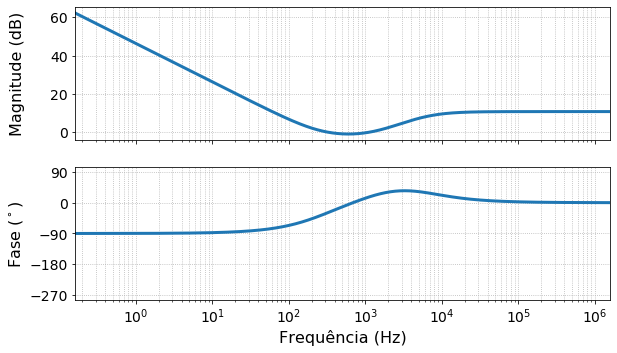

In [144]:
# Calcula resposta em frequência do controlador  
mag_Cv, phase_Cv, w = control.freqresp(Cv, w)

# Grafico de Bode do Controlador
fig, ax = plt.subplots(2,1, sharex='col')

ax[0].plot(w/2/np.pi, 20*np.log10(mag_Cv), linewidth=3)
ax[1].plot(w/2/np.pi, phase_Cv*180/np.pi, linewidth=3)

ax[1].set_xlabel(r'Frequência (Hz)', fontsize=16)
ax[0].set_ylabel(r'Magnitude (dB)', fontsize=16)
ax[1].set_ylabel(r'Fase ($^\circ$)', fontsize=16)

ax[1].set_xscale('log')

ax[1].set_xlim(w[0]/2/np.pi,w[-1]/2/np.pi)
ax[1].set_ylim(-285,105)
ax[1].set_yticks([-270, -180, -90, 0, 90])

fig.set_size_inches(9.6, 5.4)

ax[0].grid(which='both', linestyle=':')
ax[1].grid(which='both', linestyle=':')

ax[0].tick_params(axis='both', which='major', labelsize=14)
ax[1].tick_params(axis='both', which='major', labelsize=14)

fig.align_ylabels(ax)

plt.savefig('Relatorio/Imagens/Graficos/Bode_Controlador.pdf')

##### Do loop com o controlador projetado

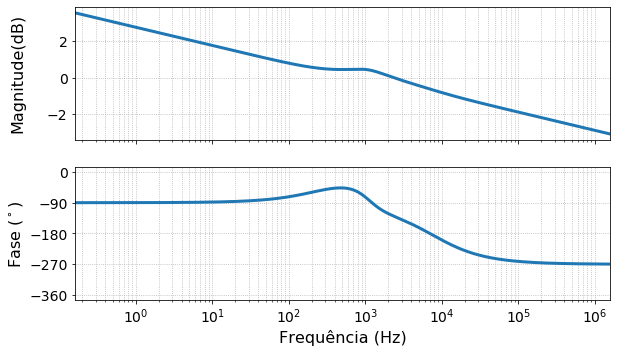

In [145]:
# Calcula a resposta em frequencia
mag_FTMACv, fase_FTMACv, w = control.freqresp(Cv*FTMA, w)

# Ajusta a fase para trabalhar apenas com valores menores que 0º
fase_FTMACv = np.array([fase if fase < 0 else -np.pi - (np.pi-fase) for fase in fase_FTMACv])

# Grafico de Bode da FTMA
fig, ax = plt.subplots(2,1, sharex='col')

ax[0].plot(w/2/np.pi, np.log10(mag_FTMACv), linewidth=3)
ax[1].plot(w/2/np.pi, fase_FTMACv*180/np.pi, linewidth=3)

ax[1].set_xlabel(r'Frequência (Hz)', fontsize=16)
ax[0].set_ylabel(r'Magnitude(dB)', fontsize=16)
ax[1].set_ylabel(r'Fase ($^\circ$)', fontsize=16)

ax[1].set_xscale('log')

ax[1].set_xlim(w[0]/2/np.pi,w[-1]/2/np.pi)
ax[1].set_ylim(-375,15)
ax[1].set_yticks([-360, -270, -180, -90, 0])

fig.set_size_inches(9.6, 5.4)

ax[0].grid(which='both', linestyle=':')
ax[1].grid(which='both', linestyle=':')

ax[0].tick_params(axis='both', which='major', labelsize=14)
ax[1].tick_params(axis='both', which='major', labelsize=14)

fig.align_ylabels(ax)

plt.savefig('Relatorio/Imagens/Graficos/Bode_FTMACv.pdf')

In [146]:
# Mede margem de fase e frequencia de crossover para validar o controlador projetado
margem_ganho, margem_fase, omega_mg, omega_mf = control.margin(FTMA*Cv)
print('Margem de Fase (º) = ', margem_fase)
print('Frequência de crossover (Hz) = ', omega_mf/2/np.pi)

Margem de Fase (º) =  50.65991704808687
Frequência de crossover (Hz) =  2365.812489029457


### Resposta do sistema

#### Modelos de pequenos Sinais

In [147]:
# Modelo em Malha Aberta
C_ps = np.array([[0,1]])
D_ps = np.array([[0,0,0,0]])
MA = control.ss(A_ps, B_ps, C_ps, D_ps)

In [148]:
# Modelo em Malha Fechada
Cv_ss = control.tf2ss(Cv)
H_ss = control.tf2ss(H)
PWM_ss = control.tf2ss(PWM)

MF = control.append(Cv_ss, PWM_ss, MA, H_ss)

connections = [[1,-4],[2,1],[3,0],[4,0],[5,0],[6,2],[7,3]]

MF = control.connect(MF, connections, [1, 3, 4, 5], [3])

#### Resposta a perturbação de carga

In [149]:
# Tempo de simulação
t = np.linspace(0,110e-3, 10000)
# Monta a matriz de entradas retirando os valores médios
Vref = np.zeros(t.shape)
Vg = np.zeros(t.shape)#np.array([0 if T < 50e-3 else 2*np.sin(240*np.pi*T) for T in t])
VD = np.zeros(t.shape)
deltaIR = np.array([0 if T < 60e-3 else 0.5 for T in t])#np.zeros(t.shape)
d = np.zeros(t.shape)

inputs_MA = np.vstack([Vg, VD, deltaIR, d])
inputs_MF = np.vstack([Vref, Vg, VD , deltaIR])

# Calcula as saidas para malha aberta
out = control.forced_response(MA, t, inputs_MA , [0,0])
V_MA = np.add(out[1], X_ps[1]).T

# Calcula as saidas para malha aberta
out = control.forced_response(MF, t, inputs_MF , [0,0,0,0])
V_MF = np.add(out[1], X_ps[1]).T

C:\Program Files\Python37\lib\site-packages\scipy\sparse\linalg\matfuncs.py:716: LinAlgWarning: Ill-conditioned matrix (rcond=3.38374e-17): result may not be accurate.
  return solve(Q, P)


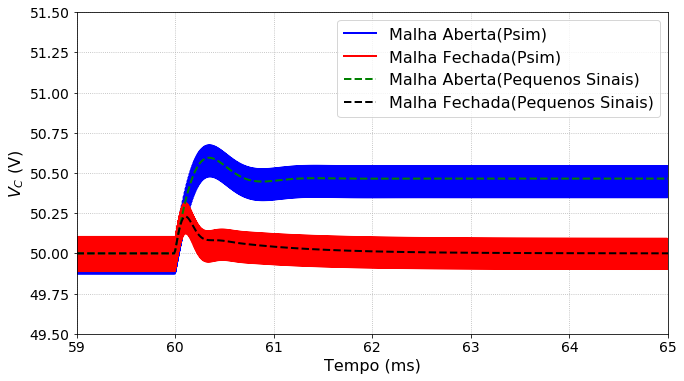

In [150]:
# Lê os Resultados do Psim 
psim = pd.read_csv('Psim/Ctrl_Pert_deltaIR.csv')
t_psim = psim['Time'].to_numpy()
V_MA_psim = psim['MA_Vo'].to_numpy()
V_MF_psim = psim['MF_Vo*10'].to_numpy()

# Resultados de Corrente
plt.plot(t_psim*1e3,V_MA_psim, label='Malha Aberta(Psim)', linewidth=2, color='b')
plt.plot(t_psim*1e3,V_MF_psim, label='Malha Fechada(Psim)', linewidth=2, color='r')
plt.plot(t*1e3,V_MA, label='Malha Aberta(Pequenos Sinais)', linewidth=2,  linestyle='--', color='g')
plt.plot(t*1e3,V_MF, label='Malha Fechada(Pequenos Sinais)', linewidth=2, linestyle='--', color='k')
plt.xlabel(r'Tempo (ms)', fontsize=16)
plt.ylabel(r'$V_C$ (V)', fontsize=16)
plt.xlim(59,65)
plt.ylim(49.5,51.5)
plt.gcf().set_size_inches(9.6, 5.4)
plt.legend(fontsize=16)
plt.grid(which='both', linestyle=':')
plt.gca().tick_params(axis='both', which='major', labelsize=14)
plt.tight_layout()
plt.savefig('Relatorio/Imagens/Graficos/Controlador_Perturbacao_Carga.pdf')
plt.show()

#### Resposta a perturbação de Vg

In [151]:
# Tempo de simulação
t = np.linspace(0,110e-3, 10000)
# Monta a matriz de entradas retirando os valores médios
Vref = np.zeros(t.shape)
Vg = np.array([0 if T < 60e-3 else 2*np.sin(240*np.pi*T) for T in t])#np.zeros(t.shape)
VD = np.zeros(t.shape)
deltaIR = np.zeros(t.shape)#np.array([0 if T < 50e-3 else 0.5 for T in t])
d = np.zeros(t.shape)

inputs_MA = np.vstack([Vg, VD, deltaIR, d])
inputs_MF = np.vstack([Vref, Vg, VD , deltaIR])

# Calcula as saidas para malha aberta
out = control.forced_response(MA, t, inputs_MA , [0,0])
V_MA = np.add(out[1], X_ps[1]).T

# Calcula as saidas para malha aberta
out = control.forced_response(MF, t, inputs_MF , [0,0,0,0])
V_MF = np.add(out[1], X_ps[1]).T

C:\Program Files\Python37\lib\site-packages\scipy\sparse\linalg\matfuncs.py:716: LinAlgWarning: Ill-conditioned matrix (rcond=3.38374e-17): result may not be accurate.
  return solve(Q, P)


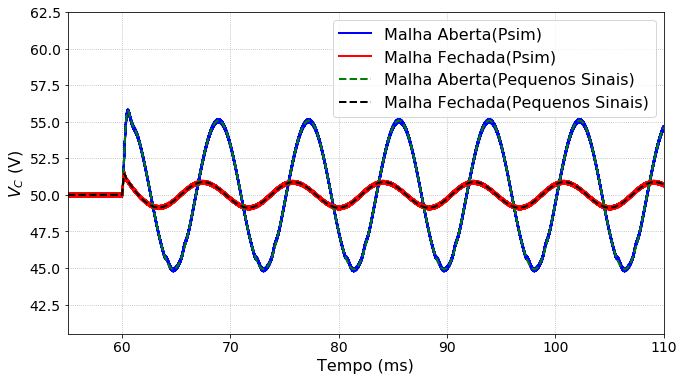

In [152]:
# Lê os Resultados do Psim 
psim = pd.read_csv('Psim/Ctrl_Pert_Vg.csv')
t_psim = psim['Time'].to_numpy()
V_MA_psim = psim['MA_Vo'].to_numpy()
V_MF_psim = psim['MF_Vo*10'].to_numpy()

# Resultados de Corrente
plt.plot(t_psim*1e3,V_MA_psim, label='Malha Aberta(Psim)', linewidth=2, color='b')
plt.plot(t_psim*1e3,V_MF_psim, label='Malha Fechada(Psim)', linewidth=2, color='r')
plt.plot(t*1e3,V_MA, label='Malha Aberta(Pequenos Sinais)', linewidth=2,  linestyle='--', color='g')
plt.plot(t*1e3,V_MF, label='Malha Fechada(Pequenos Sinais)', linewidth=2, linestyle='--', color='k')
plt.xlabel(r'Tempo (ms)', fontsize=16)
plt.ylabel(r'$V_C$ (V)', fontsize=16)
plt.xlim(55,110)
plt.ylim(40.5,62.5)
plt.gcf().set_size_inches(9.6, 5.4)
plt.legend(fontsize=16, loc='upper right')
plt.grid(which='both', linestyle=':')
plt.gca().tick_params(axis='both', which='major', labelsize=14)
plt.tight_layout()
plt.savefig('Relatorio/Imagens/Graficos/Controlador_Perturbacao_Vg.pdf')
plt.show()

#### Resposta a perturbação de carga e Vg

In [153]:
# Tempo de simulação
t = np.linspace(0,110e-3, 10000)
# Monta a matriz de entradas retirando os valores médios
Vref = np.zeros(t.shape)
Vg = np.array([0 if T < 60e-3 else 2*np.sin(240*np.pi*T) for T in t])#np.zeros(t.shape)
VD = np.zeros(t.shape)
deltaIR = np.array([0 if T < 60e-3 else 0.5 for T in t])#np.zeros(t.shape)
d = np.zeros(t.shape)

inputs_MA = np.vstack([Vg, VD, deltaIR, d])
inputs_MF = np.vstack([Vref, Vg, VD , deltaIR])

# Calcula as saidas para malha aberta
out = control.forced_response(MA, t, inputs_MA , [0,0])
V_MA = np.add(out[1], X_ps[1]).T

# Calcula as saidas para malha aberta
out = control.forced_response(MF, t, inputs_MF , [0,0,0,0])
V_MF = np.add(out[1], X_ps[1]).T

C:\Program Files\Python37\lib\site-packages\scipy\sparse\linalg\matfuncs.py:716: LinAlgWarning: Ill-conditioned matrix (rcond=3.38374e-17): result may not be accurate.
  return solve(Q, P)


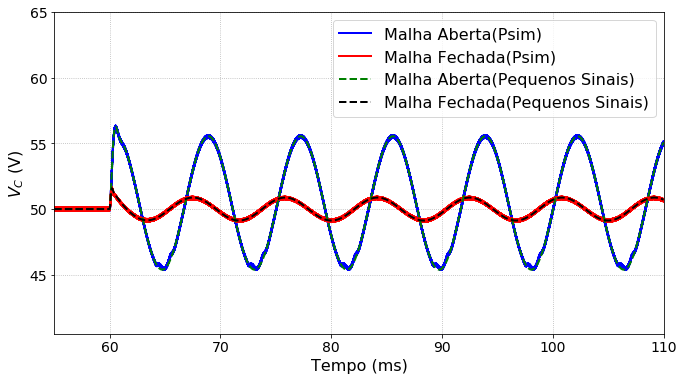

In [154]:
# Lê os Resultados do Psim 
psim = pd.read_csv('Psim/Ctrl_Pert_Ambos.csv')
t_psim = psim['Time'].to_numpy()
V_MA_psim = psim['MA_Vo'].to_numpy()
V_MF_psim = psim['MF_Vo*10'].to_numpy()

# Resultados de Corrente
plt.plot(t_psim*1e3,V_MA_psim, label='Malha Aberta(Psim)', linewidth=2, color='b')
plt.plot(t_psim*1e3,V_MF_psim, label='Malha Fechada(Psim)', linewidth=2, color='r')
plt.plot(t*1e3,V_MA, label='Malha Aberta(Pequenos Sinais)', linewidth=2,  linestyle='--', color='g')
plt.plot(t*1e3,V_MF, label='Malha Fechada(Pequenos Sinais)', linewidth=2, linestyle='--', color='k')
plt.xlabel(r'Tempo (ms)', fontsize=16)
plt.ylabel(r'$V_C$ (V)', fontsize=16)
plt.xlim(55,110)
plt.ylim(40.5,65)
plt.gcf().set_size_inches(9.6, 5.4)
plt.legend(fontsize=16, loc='upper right')
plt.grid(which='both', linestyle=':')
plt.gca().tick_params(axis='both', which='major', labelsize=14)
plt.tight_layout()
plt.savefig('Relatorio/Imagens/Graficos/Controlador_Perturbacao_Ambos.pdf')
plt.show()

## Area de Testes

In [155]:
# Códigos de teste
# print(A_on)
# print(A_off)
# print(A_on-A_off)
# U = np.array([[Vg], [VD]])
# X = np.linalg.inv(A_med)@B_med@U
# ID = np.array([[1,0], [0,1]])

# print(X) 
# sys_on = control.ss(A_on, B_on, C_on, D_on)
# sys_off = control.ss(A_off, B_off, C_off, D_off)

# sys_med =  control.ss(A_med, B_med, C_on, D_on)

# t, y = control.step_response(sys_med, input=0)

# plt.plot(t, y[0][0])
